# Traffic sign classifier neural network
```Trunk code by Vivek Kumar, commentary and attempts to develop the LeCun et al. solution by M.L.```

### Goals of this exercise
* Reproduce LeCun & team classification results using Python ML-libraries
* Improve if possible by trying the following
    * Standardize luminosity and colours (LeCun et al. ended up dropping colours, which I see as a fail, human perceptual system normalizes light and colour hues, how about trying the same and retaining colour as a classifying input? It is pretty solid classifier - it seems frankly stupid to let the neural network be misguided due to seeing a yellow in the dark as different colour than yellow in the light? I think we could attempt to standardize colours so that the machine sees "a yellow" and "a red" etc. and try what kind of predictions we end up with.)
    * ...would the above be achieved by a colour classifying SOM -layer (https://www.slideshare.net/raphaelkiminya/kohonen-self-organizing-maps)
    * adding jitter was also suggested



In [1]:
import os
os.getcwd()

'C:\\Users\\andro\\repositories\\dscipy_warmups\\springboard\\mentor_exercises'

In [2]:
import numpy as np
np.version.version

'1.16.2'

In [3]:
import keras


Using TensorFlow backend.


In [4]:
# we need this for handling serialized binary objects 
# (which the pics are apparently)
# Check out joblib as well
import pickle

# OK, but which sets are the ones you used and on what basis did you select?
# there was quite a plethora of different datasets on offer
# haar, hog, gt, hue-hist? Wut?
# Did you do pre-processing other than what is seen here, the "multilabel binarizer"? What does it do?
# If yes, what exactly?
     # 100K  GTSRB_Final_Test_GT.zip
     # 305M  GTSRB_Final_Test_Haar.zip
     # 279M  GTSRB_Final_Test_HOG.zip
     # 4.6M  GTSRB_Final_Test_HueHist.zip
     
     # 945M  GTSRB_Final_Training_Haar.zip
     # 864M  GTSRB_Final_Training_HOG.zip
     #  18M  GTSRB_Final_Training_HueHist.zip
     
     #  85M  GTSRB_Final_Test_Images.zip
     # 264M  GTSRB_Final_Training_Images.zip
    # Vivek split some of the training data to the validation population

# the source data from the German site does not match this one, so how did we get here?
training_file   = 'C:\\Users\\andro\\repositories\\dscipy_warmups\\springboard\\mentor_exercises\\data\\traffic-signs-data\\train.p'
validation_file = 'C:\\Users\\andro\\repositories\\dscipy_warmups\\springboard\\mentor_exercises\\data\\traffic-signs-data\\valid.p'
testing_file    = 'C:\\Users\\andro\\repositories\\dscipy_warmups\\springboard\\mentor_exercises\\data\\traffic-signs-data\\test.p'

# loading in the image populations
# ..have you had binary file corruption on Windows with this "read binary" -mode
# try without b-option first
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# I need to check the schema/shape of the pickle
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


In [5]:
import numpy as np

# population samples to vars with len
n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)

image_shape = X_train.shape[1:] # all of the second column

# just appending the populations
classes = np.append(y_train, y_valid)
classes = np.append(classes, y_test)
n_classes = len(set(classes))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


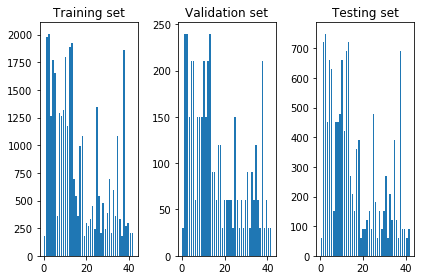

In [7]:
# Print histograms of training and testing distributions with 43 bins
# 43 is the number of actual labels, hence the bins.

import matplotlib.pyplot as plt

plt.subplot(1,3,1)
hist, bins = np.histogram(y_train, bins=43)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.title('Training set')

plt.subplot(1,3,2)
hist, bins = np.histogram(y_valid, bins=43)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.title('Validation set')

plt.subplot(1,3,3)
hist, bins = np.histogram(y_test, bins=43)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.title('Testing set')

plt.tight_layout()
plt.show()

In [8]:
# RGB channels handling here - to greyscale
# but where is the actual image information - that is pixel greyscale values?
# 1) (here I would be doing a split after first trying it like this)
# 2) try it with colour as is
# 3) try it with colour averaging, which should cancel out the lighting conditions complained about by original authors
X_train = np.sum(X_train/3, axis=3, keepdims=True)
X_valid = np.sum(X_valid/3, axis=3, keepdims=True)
X_test = np.sum(X_test/3, axis=3, keepdims=True)

X_train = (X_train - 128)/128
X_valid = (X_valid - 128)/128
X_test = (X_test - 128)/128

In [9]:
# bunch of different CNN layer types here: convolution, max-pooling
# Rectified linear units (relu) chosen to enhance non-linear properties of network 
# (but isn't this a layer type in itself, it is in "activation")
# 2 kinds of layers - function layers, weight layers

# What do strides do in NN usage?
# input_shape 32,32,1 ...32 px * 32 px and..1?

# I installed the CPU -version...what about the GPU -version?

from keras.models import Model
from keras.layers import Input
# Flatten: a vector from a matrix: input, tensor of 3 dimensions (height width channels) - output will be vector
# Dense: vector to vectors 
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Concatenate

from keras.layers.convolutional import AtrousConvolution2D
from keras import backend as K # when doing stuff not in Keras, new layer, new callback -> allows extending Keras


def model_traffic_sign(input_tensor=None):
    input_shape = (32, 32, 1) # for colour images, use all channels

    img_input = Input(shape=input_shape)
    
# how does this layering work - you just re-assign x...and then build another layer, 
# at the end of which you kinda concatenate the previous layer?
# Which documentation part should I read here? - keras.layers -api? - Convolution2D and MaxPooling2D apis


    # conv_1
    x = Convolution2D(6, (5, 5), activation='relu', padding='valid', name='block1_conv1')(img_input)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # conv_2
    x = Convolution2D(16, (5, 5), activation='relu', padding='valid', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    
    layer2 = x
    
    x = Convolution2D(400, (5, 5), activation='relu', padding='valid', name='block2_conv1')(x)
    #x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    
    x = Flatten()(x)
    layer2_flat = Flatten()(layer2)
    
    x = Concatenate()([x, layer2_flat])
    #x = Dense(120, activation="relu")(x)
    x = Dense(43, activation="softmax")(x)

    
    model = Model(img_input, x)

    return model

In [10]:
# stochastic gradient descent optimization algo variant
from keras.optimizers import Adam 

model = model_traffic_sign()
optim = Adam(lr = 0.0009)   # what is this magic number and where is it from? 
                            # ..lowest learning rate you can practically use less than 0.001
model.compile(optim, loss='categorical_crossentropy')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 28, 28, 6)    156         input_1[0][0]                    
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 14, 14, 6)    0           block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 10, 10, 16)   2416        block1_pool[0][0]                
_____________________________________

In [11]:
# Keras utils in general has lots of nice stuff, read.
# 
from tensorflow.keras.utils import Sequence 
class MySequence(Sequence):

        def __init__(self, x_set, y_set, batch_size):
            self.x, self.y = x_set, y_set
            self.batch_size = batch_size

        def __len__(self):
            return math.ceil(len(self.x) / self.batch_size)

        def __getitem__(self, idx):
            batch_x = self.x[idx * self.batch_size:(idx + 1) *
            self.batch_size]
            batch_y = self.y[idx * self.batch_size:(idx + 1) *
            self.batch_size]

            return batch_x,  batch_y

In [12]:
# Modifying the Raw labels to a form which can be used by our model 
from sklearn.preprocessing import MultiLabelBinarizer # again read docs but basically one-hot coding of labels

classes = classes.reshape(len(classes),1)
lbl_enc = MultiLabelBinarizer()
lbl_enc.fit(classes)
lbs_train = lbl_enc.transform(y_train.reshape(len(y_train), 1))
lbs_valid = lbl_enc.transform(y_valid.reshape(len(y_valid), 1))
lbs_test = lbl_enc.transform(y_test.reshape(len(y_test), 1))

In [14]:
from sklearn.utils import shuffle # randomizing of training data

n_epoches = 20
batch_size = 256
n_steps = int(n_train / batch_size)

for i in range(n_epoches):
    X_train, lbs_train = shuffle(X_train, lbs_train)
    data_gen = MySequence(X_train, lbs_train, batch_size=batch_size)

    for j in range(n_steps):
        x, y = data_gen[j]
        loss = model.train_on_batch(x, y)
        
    val_pred = model.predict(X_valid)
    pred = np.argmax(val_pred, 1)
    true = np.where(lbs_valid == 1)[1]
    correct = sum(np.equal(true, pred))
    val_acc = correct/len(X_valid)
    print("loss: {}".format(loss))
    print("epoch no-> {} val_acc-> {}".format(i, val_acc))
        

loss: 0.00893784686923027
epoch no-> 0 val_acc-> 0.9260770975056689
loss: 0.010782591998577118
epoch no-> 1 val_acc-> 0.9222222222222223
loss: 0.007235602010041475
epoch no-> 2 val_acc-> 0.9210884353741496
loss: 0.007475446909666061
epoch no-> 3 val_acc-> 0.9238095238095239
loss: 0.008697006851434708
epoch no-> 4 val_acc-> 0.9006802721088435
loss: 0.021122440695762634
epoch no-> 5 val_acc-> 0.9240362811791383
loss: 0.008197229355573654
epoch no-> 6 val_acc-> 0.9294784580498866
loss: 0.014335260726511478
epoch no-> 7 val_acc-> 0.9365079365079365
loss: 0.06757121533155441
epoch no-> 8 val_acc-> 0.9340136054421768
loss: 0.0011150178033858538
epoch no-> 9 val_acc-> 0.9328798185941043
loss: 0.004076881799846888
epoch no-> 10 val_acc-> 0.9356009070294785
loss: 0.0035826596431434155
epoch no-> 11 val_acc-> 0.9317460317460318
loss: 0.010618667118251324
epoch no-> 12 val_acc-> 0.9303854875283447
loss: 0.004813934676349163
epoch no-> 13 val_acc-> 0.9111111111111111
loss: 0.009564138017594814
epo

In [18]:
test_pred = model.predict(X_test)
pred = np.argmax(test_pred, 1)
true = np.where(lbs_test == 1)[1]
correct = sum(np.equal(true, pred))
test_acc = correct/len(X_test)

In [19]:
train_pred = model.predict(X_train)
pred = np.argmax(train_pred, 1)
true = np.where(lbs_train == 1)[1]
correct = sum(np.equal(true, pred))
train_acc = correct/len(X_train)

### ...and how do I see the model quality? Can't run a "model.summar()" against a numpy array

In [ ]:
# add precision recall too - scikit learn for that